# Finite-Length Kitaev Ladder SVD


According to some analytic paper, in the Kitaev ladder, the local operator `d`'s should be all good quantum numbers and also commute with each other, and therefore they are acting like some kind of gauge symmetry; furthermore, it is totally fine to randomly fix the gauage and make use of a single gauge fixing to derive a global phase diagram.

However, it is not straight forward that local gauge symmetry has to be randomly fixable. If two operators `A` and `B` are commutable with each other, the only conclusion we can get is that the eigenstates `v` of `A` in the same eigenvalues `k` will remain the same eigenvalues after acted by `B`, i.e. `Av = kv => ABv = BAv = Bkv = kBv = k(Bv)`. Generally, we can only see that commutable operator will not transform the eigenstates out side of its previous energy sector; in particular, a ground state will not be excited by a commutable operator, but we are never sure whether or not it is also an eigenstate of this operator.

However, the random choice of gauge fixing implies that for a Kitaev ladder of length `L` (we define the width of a Kitaev ladder to be `2`), there will be `2^L` ground states. We can reasonably guess that this is again based on the assumption that each ground state must be the eigenstate of each local operator.

The result of gauge fixing shows discrepencies with our iDMRG simulation results, and two papers choosing two different fixing present discrepencies with each other. On this observation, we can cautiously believe that, their random gauge fixing choices are not so proper as they guessed; at least, their gauge fixing cannot be applied to the global phase diagram of Kitaev ladders.

But to demonstrate that they are kind of wrong is difficult: after JW transformation and Majorana transformation, the Hamiltonian has changed a lot and is no longer the same as before. This causes problems when we want to decide how to design the explicit matrix formula. To escape from such difficulty, we can consider count the degeneracy of ground states, i.e. the dimension of the ground state space.

## Import

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate

from kitaev_ladder import KitaevLadderModel, fDMRG_KL, run_atomic
from tenpy.algorithms.exact_diag import ExactDiag

## Using TeNPy Interfaces

In [2]:
L=3
Jx=1
Jy=1
Jz=1
bc_MPS='finite'
bc='open'
order='default'
verbose=1

model_params = dict(L=L, Jx=Jx, Jy=Jy, Jz=Jz, bc_MPS=bc_MPS, bc=bc, conserve=None, order=order, verbose=verbose)
M = KitaevLadderModel(model_params)
M.bc = 'finite'
ExactDiag.from_H_mpo(M)

Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=1 for config KitaevLadderModel
Reading 'Jz'=1 for config KitaevLadderModel


AttributeError: 'KitaevLadderModel' object has no attribute 'sites'

The interface provided by TeNPy just doesn't work = =.

## Brute-force Matrix Construction & Diagonalization

In [10]:
# parameter setting
L = 3 # here the L is the number of unit cells
J = 1
g = 1

### An Ising Demo

Here is an example code from the official documentation of `TeNPy`.

In [53]:
# get single site operaors
sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
id = sparse.csr_matrix(np.eye(2))
sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
sz_list = []
for i_site in range(L):
    x_ops = [id] * L
    z_ops = [id] * L
    x_ops[i_site] = sx
    z_ops[i_site] = sz
    X = x_ops[0]
    Z = z_ops[0]
    for j in range(1, L):
        X = sparse.kron(X, x_ops[j], 'csr')
        Z = sparse.kron(Z, z_ops[j], 'csr')
    sx_list.append(X)
    sz_list.append(Z)
H_xx = sparse.csr_matrix((2**L, 2**L))
H_z = sparse.csr_matrix((2**L, 2**L))
for i in range(L - 1):
    H_xx = H_xx + sx_list[i] * sx_list[(i + 1) % L]
for i in range(L):
    H_z = H_z + sz_list[i]
H = -J * H_xx - g * H_z
E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
print(E)

[-3.49395921]


Well it seems quite tedious and not straightforward to me.

We will implement the ED in our own way and demonstrate it to be consistent with `TeNPy`'s code.

### Change to Kitaev Ladder

In [2]:
# get single site operaors
sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
sy = sparse.csc_matrix(np.array([[0., -1.0j], [1.0j, 0.]]))
sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
id = sparse.csr_matrix(np.eye(2))
sigma_list = [id, sx, sy, sz]

def Sigma(op_num, site, L=12):
    assert op_num==0 or op_num==1 or op_num==2 or op_num==3
    assert site>=0 and site<L
    
    op = sigma_list[op_num]
    
    if site==0:
        return sparse.kron(op, sparse.csr_matrix(np.eye(2**(L-1))))
    elif site==L-1:
        return sparse.kron(sparse.csr_matrix(np.eye(2**(L-1))), op)
    else: 
        IA = sparse.kron(sparse.csr_matrix(np.eye(2**(site))), op)
        return sparse.kron(IA, sparse.csr_matrix(np.eye(2**(L-1-site))))

In [15]:
# parameter setting
unit_number = 3
unit_size = 4
L = unit_number * unit_size
Jx = 1
Jy = 1
Jz = 1

In [16]:
# test the complex number operation
1j * 1j

(-1+0j)

In [3]:
def get_H_Kitaev_Ladder(Jx=1, Jy=1, Jz=1, unit_number=3, bc='open'):
    # parameter setting
    unit_size = 4
    L = unit_number * unit_size

    H_xx = sparse.csr_matrix((2**L, 2**L))
    for i in range(L//2 - 1):
        site1 = 2*i + 1
        site2 = site1+1

        op_num = 1 # 1 represents x

    #     print("i = ", i)
        X1 = Sigma(op_num, site1, L=L)
        X2 = Sigma(op_num, site2, L=L)
        H_xx += X1.dot(X2)

        pass

    H_yy = sparse.csr_matrix((2**L, 2**L))
    for i in range(L//2 - 1):
        site1 = 2*i
        site2 = site1 +3

        op_num = 2
        Y1 = Sigma(op_num, site1, L=L)
        Y2 = Sigma(op_num, site2, L=L)
        H_yy += Y1.dot(Y2)

        pass
    
    if bc=='periodic':
        XN = Sigma(1, L-1, L=L)
        X1 = Sigma(1, 0, L=L)
        H_xx += XN.dot(X1)
        
        YN = Sigma(2, L-2, L=L)
        Y1 = Sigma(2, 1, L=L)
        H_yy += YN.dot(Y1)
        pass

    H_zz = sparse.csr_matrix((2**L, 2**L))
    for i in range(L//2):
        site1 = 2*i
        site2 = site1 +1

        op_num = 3
        Z1 = Sigma(op_num, site1, L=L)
        Z2 = Sigma(op_num, site2, L=L)
        H_zz += Z1.dot(Z2)

        pass

    H = Jx * H_xx + Jy * H_yy + Jz * H_zz
    
    return H
    

def exact_diagonalization_Kitaev_Ladder(Jx=1, Jy=1, Jz=1, unit_number=3, k=100, bc='open'):
    H = get_H_Kitaev_Ladder(Jx=Jx, Jy=Jy, Jz=Jz, unit_number=unit_number, bc='open')
    E, V = arp.eigsh(H, k=k, which='SA')

    print(f'The {k} lowest energies are: \n', np.sort(E))
    return E, V

In [57]:
exact_diagonalization_Kitaev_Ladder(Jz=0)

The 100 lowest energies are: 
 [-6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841
 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841
 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841
 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841
 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841
 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841
 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841
 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841
 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841
 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.98791841
 -6.98791841 -6.98791841 -6.98791841 -6.98791841 -6.09783468 -6.09783468
 -6.09783468 -6.09783468 -6.09783468 -6.09783468 -6.09783468 -6.09783468
 -6.09783468 -6.09783468 -6.09783468 -6.09783468 -6.09783468 -6.09783468
 -6.09783468 -6.0978

(array([-6.98791841, -6.98791841, -6.09783468, -6.98791841, -6.98791841,
        -6.98791841, -6.98791841, -6.98791841, -6.09783468, -6.98791841,
        -6.98791841, -6.09783468, -6.98791841, -6.98791841, -6.09783468,
        -6.98791841, -6.09783468, -6.98791841, -6.09783468, -6.98791841,
        -6.98791841, -6.09783468, -6.09783468, -6.98791841, -6.09783468,
        -6.98791841, -6.09783468, -6.98791841, -6.09783468, -6.98791841,
        -6.09783468, -6.98791841, -6.09783468, -6.98791841, -6.09783468,
        -6.98791841, -6.09783468, -6.98791841, -6.09783468, -6.98791841,
        -6.98791841, -6.09783468, -6.09783468, -6.09783468, -6.98791841,
        -6.98791841, -6.09783468, -6.98791841, -6.09783468, -6.98791841,
        -6.98791841, -6.98791841, -6.09783468, -6.09783468, -6.09783468,
        -6.09783468, -6.98791841, -6.98791841, -6.98791841, -6.98791841,
        -6.98791841, -6.98791841, -6.09783468, -6.98791841, -6.09783468,
        -6.98791841, -6.09783468, -6.98791841, -6.9

### Back to check the consistency with Ising

In [52]:
# parameter setting
L = 3
Jx = 1
g = 1

H_xx = sparse.csr_matrix((2**L, 2**L))
for i in range(L - 1):
    site1 = i
    site2 = i+1
    
    op_num = 1 # 1 represents x
    
#     print("i = ", i)
    X1 = Sigma(op_num, site1, L=L)
    X2 = Sigma(op_num, site2, L=L)
    H_xx += X1.dot(X2)
    
    pass

H_z = sparse.csr_matrix((2**L, 2**L))
for i in range(L):
    site1 = i
    
    op_num = 3
    Z1 = Sigma(op_num, site1, L=L)
    H_z += Z1
    
    pass

H = -Jx * H_xx - g * H_z
E, V = arp.eigsh(H, k=1, which='SA')

print(np.sort(E))

[-3.49395921]


Correct!

However, this can only show that our implementation of Python code is consistent with Ising model; still we don't know whether or not it is consistent with our Kitaev ladder.

Let's do the fDMRG to convince ourselves.

### Finite DMRG

In [8]:
fDMRG_KL(chi=200)

finite DMRG, Kitaev ladder model
L = 3, Jx = 1.00, Jy = 1.00, Jz = 1.00, 
Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1.0 for config KitaevLadderModel
Reading 'Jy'=1.0 for config KitaevLadderModel
Reading 'Jz'=1.0 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 12
Energy = -2.3769020374912664, S = nan, norm_err = 4.0e-14
Current memory usage 224.9 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4333e-20, max_E_trunc = 3.1086e-15
MPS bond dimens

(-2.3769020374912624,
 <kitaev_ladder.KitaevLadderModel at 0x7f4e206749d0>)

In [7]:
exact_diagonalization_Kitaev_Ladder(Jx=1,Jy=1,Jz=1)

The 100 lowest energies are: 
 [-9.50760815 -9.50760815 -9.15624404 -9.15624404 -9.15624404 -9.15624404
 -9.0609573  -9.0609573  -8.92666333 -8.92666333 -8.92666333 -8.92666333
 -8.9031713  -8.9031713  -8.80415181 -8.80415181 -8.80415181 -8.80415181
 -8.71547245 -8.71547245 -8.71547245 -8.71547245 -8.69413703 -8.69413703
 -8.69413703 -8.69413703 -8.67978022 -8.67978022 -8.64095298 -8.64095298
 -8.64095298 -8.64095298 -8.5394743  -8.5394743  -8.5394743  -8.5394743
 -8.5359875  -8.5359875  -8.5359875  -8.5359875  -8.49852706 -8.49852706
 -8.49852706 -8.49852706 -8.43472094 -8.43472094 -8.43472094 -8.43472094
 -8.40868717 -8.40868717 -8.36636459 -8.36636459 -8.36375738 -8.36375738
 -8.36375738 -8.36375738 -8.31391071 -8.31391071 -8.31391071 -8.31391071
 -8.30494151 -8.30494151 -8.30494151 -8.30494151 -8.29465105 -8.29465105
 -8.29465105 -8.29465105 -8.28543917 -8.28543917 -8.28543917 -8.28543917
 -8.26399295 -8.26399295 -8.19012984 -8.19012984 -8.19012984 -8.19012984
 -8.18799635 -8.18799

(array([-9.50760815, -9.50760815, -9.0609573 , -9.15624404, -9.15624404,
        -9.0609573 , -8.92666333, -9.15624404, -9.15624404, -8.80415181,
        -8.92666333, -8.9031713 , -8.9031713 , -8.92666333, -8.80415181,
        -8.92666333, -8.80415181, -8.71547245, -8.67978022, -8.67978022,
        -8.80415181, -8.71547245, -8.71547245, -8.64095298, -8.5394743 ,
        -8.71547245, -8.64095298, -8.5394743 , -8.69413703, -8.69413703,
        -8.69413703, -8.69413703, -8.64095298, -8.64095298, -8.5394743 ,
        -8.5359875 , -8.5359875 , -8.5359875 , -8.40868717, -8.40868717,
        -8.36636459, -8.5394743 , -8.5359875 , -8.49852706, -8.49852706,
        -8.49852706, -8.49852706, -8.36636459, -8.26399295, -8.43472094,
        -8.43472094, -8.43472094, -8.43472094, -8.36375738, -8.26399295,
        -8.36375738, -8.36375738, -8.09783468, -8.09783468, -7.98518751,
        -8.31391071, -8.31391071, -8.31391071, -8.36375738, -8.18799635,
        -8.18799635, -7.98518751, -8.31391071, -8.3

In [9]:
9.50760815/2.3769020374912624

4.000000000014704

Maybe TeNPy returns the energy divided by the site number in one single unitcell?

In [12]:
Jx = np.random.rand()
Jy = np.random.rand()
Jz = np.random.rand()
L = 3

E, psi, M = fDMRG_KL(Jx=Jx, Jy=Jy, Jz=Jz, L=L)
Energies, Vectors = exact_diagonalization_Kitaev_Ladder(Jx=Jx, Jy=Jy, Jz=Jz, unit_number=L)

print(f'The difference between fDMRG and ED for J = ({Jx}, {Jy}, {Jz}) is E_fDMRG - E_ED = {E*4 - Energies[0]}')

finite DMRG, Kitaev ladder model
L = 3, Jx = 0.25, Jy = 0.60, Jz = 0.95, 
Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=0.2476925437078228 for config KitaevLadderModel
Reading 'Jy'=0.5968215051620674 for config KitaevLadderModel
Reading 'Jz'=0.9491845079109834 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 12
Energy = -1.6390532327636469, S = nan, norm_err = 5.9e-12
Current memory usage 228.5 MB, time elapsed: 2.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3236e

So we can see that the difference between fDMRG and ED is only `~1e-13`, which means basically this is the machine precision error.
Therefore, we can reasonably trust the result of fDMRG.

In [15]:
# Params setting
Jx = 1
Jy = -1
Jz = 1

# Loop control
max_trials = 10
max_E_err = 1e-10

# Stored data
orthogonal_to = []
energy = []

for i in range(max_trials):
    if i > 1: # there are already 2 or more energies
        if energy[i-1] - energy[i-2] > max_E_err:
            break
    
    E, psi, M = fDMRG_KL(Jx=Jx, Jy=Jy, Jz=Jz, L=30, chi=30, orthogonal_to=orthogonal_to)
    energy.append(E)
    orthogonal_to.append(psi.copy())
    
    pass

print("Energy list : ", energy)


finite DMRG, Kitaev ladder model
L = 30, Jx = 1.00, Jy = -1.00, Jz = 1.00, 
Reading 'L'=30 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=-1 for config KitaevLadderModel
Reading 'Jz'=1 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 120
Energy = -25.0245350434565559, S = nan, norm_err = 9.3e-08
Current memory usage 483.3 MB, time elapsed: 43.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9519e-

sweep 40, age = 120
Energy = -25.0245350481217912, S = 1.2131131715904644, norm_err = 7.4e-08
Current memory usage 483.3 MB, time elapsed: 165.9 s
Delta E = -1.9478e-11, Delta S = 7.6419e-11 (per sweep)
max_trunc_err = 2.0071e-10, max_E_trunc = 5.5032e-10
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 16, 16, 8, 8, 4, 2]
DMRG finished after 40 sweeps.
total size = 120, maximum chi = 30
E = -25.0245350481218
final bond dimensions:  [2, 4, 8, 8, 16, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 120, maximum chi = 30
E = -24.9351036479603
final bond dimensions:  [2, 4, 8, 8, 16, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 20, 16, 8, 8, 4, 2]
Energy list :  [-25.024535048057302, -25.02453504812179, -24.93510364796031]


In [ ]:

# Params setting
Jx = 1
Jy = -1
Jz = 1

# Loop control
max_trials = 10
max_E_err = 1e-10

# Stored data
orthogonal_to = []
energy = []

for i in range(max_trials):
    if i > 1: # there are already 2 or more energies
        if energy[i-1] - energy[i-2] > max_E_err:
            break
    
    E, psi, M = fDMRG_KL(Jx=Jx, Jy=Jy, Jz=Jz, L=30, chi=30, orthogonal_to=orthogonal_to)
    energy.append(E)
    orthogonal_to.append(psi.copy())
    
    pass

print("Energy list : ", energy)


In [7]:
exact_diagonalization_Kitaev_Ladder(Jx=Jx, Jy=Jy, Jz=Jz, unit_number=3)

The 100 lowest energies are: 
 [-9.50760815 -9.50760815 -9.15624404 -9.15624404 -9.15624404 -9.15624404
 -9.0609573  -9.0609573  -8.92666333 -8.92666333 -8.92666333 -8.92666333
 -8.9031713  -8.9031713  -8.80415181 -8.80415181 -8.80415181 -8.80415181
 -8.71547245 -8.71547245 -8.71547245 -8.71547245 -8.69413703 -8.69413703
 -8.69413703 -8.69413703 -8.67978022 -8.67978022 -8.64095298 -8.64095298
 -8.64095298 -8.64095298 -8.5394743  -8.5394743  -8.5394743  -8.5394743
 -8.5359875  -8.5359875  -8.5359875  -8.5359875  -8.49852706 -8.49852706
 -8.49852706 -8.49852706 -8.43472094 -8.43472094 -8.43472094 -8.43472094
 -8.40868717 -8.40868717 -8.36636459 -8.36636459 -8.36375738 -8.36375738
 -8.36375738 -8.36375738 -8.31391071 -8.31391071 -8.31391071 -8.31391071
 -8.30494151 -8.30494151 -8.30494151 -8.30494151 -8.29465105 -8.29465105
 -8.29465105 -8.29465105 -8.28543917 -8.28543917 -8.28543917 -8.28543917
 -8.26399295 -8.26399295 -8.19012984 -8.19012984 -8.19012984 -8.19012984
 -8.18799635 -8.18799

(array([-9.50760815, -9.50760815, -9.0609573 , -9.15624404, -9.15624404,
        -9.0609573 , -8.92666333, -9.15624404, -9.15624404, -8.80415181,
        -8.92666333, -8.9031713 , -8.9031713 , -8.92666333, -8.92666333,
        -8.80415181, -8.67978022, -8.80415181, -8.67978022, -8.80415181,
        -8.69413703, -8.69413703, -8.64095298, -8.69413703, -8.71547245,
        -8.71547245, -8.71547245, -8.71547245, -8.69413703, -8.64095298,
        -8.64095298, -8.64095298, -8.5359875 , -8.5359875 , -8.5394743 ,
        -8.5394743 , -8.5394743 , -8.5359875 , -8.40868717, -8.40868717,
        -8.26399295, -8.5394743 , -8.5359875 , -8.49852706, -8.49852706,
        -8.36636459, -8.36636459, -8.49852706, -8.49852706, -8.43472094,
        -8.43472094, -8.43472094, -8.43472094, -8.26399295, -8.36375738,
        -8.09783468, -8.36375738, -8.36375738, -8.09783468, -8.36375738,
        -8.18799635, -8.18799635, -7.98518751, -7.98518751, -8.30494151,
        -8.30494151, -8.30494151, -8.31391071, -8.3

In [14]:
Jx = np.random.rand()
Jy = np.random.rand()
Jz = np.random.rand()
L = 3

# E, psi, M = fDMRG_KL(Jx=Jx, Jy=Jy, Jz=Jz, L=L)
Energies, Vectors = exact_diagonalization_Kitaev_Ladder(Jx=Jx, Jy=Jy, Jz=Jz, unit_number=L)

# print(f'The difference between fDMRG and ED for J = ({Jx}, {Jy}, {Jz}) is E_fDMRG - E_ED = {E*4 - Energies[0]}')

The 100 lowest energies are: 
 [-4.05093637 -4.05093637 -4.04405079 -4.04405079 -4.0436275  -4.0436275
 -4.0436275  -4.0436275  -4.0382333  -4.0382333  -4.0382333  -4.0382333
 -4.03762396 -4.03762396 -4.03686458 -4.03686458 -4.03686458 -4.03686458
 -4.0330456  -4.0330456  -4.0330456  -4.0330456  -4.03212136 -4.03212136
 -4.03212136 -4.03212136 -4.03129414 -4.03129414 -4.03129414 -4.03129414
 -4.030992   -4.030992   -4.02709756 -4.02709756 -4.02709756 -4.02709756
 -4.02695171 -4.02695171 -4.02655361 -4.02655361 -4.02655361 -4.02655361
 -4.02622831 -4.02622831 -4.02622831 -4.02622831 -4.02486858 -4.02486858
 -4.02486858 -4.02486858 -4.02440209 -4.02440209 -4.02398396 -4.02398396
 -4.02315727 -4.02315727 -4.02315727 -4.02315727 -4.02290172 -4.02290172
 -4.0224953  -4.0224953  -4.02247257 -4.02247257 -4.0216541  -4.0216541
 -4.0216541  -4.0216541  -4.02129112 -4.02129112 -4.02129112 -4.02129112
 -4.02058117 -4.02058117 -4.02058117 -4.02058117 -4.02046343 -4.02046343
 -4.02046343 -4.0204634

Test if the periodic boundary condition can eliminate such degeneracies. If so, there may be edge states.

In [29]:
Jx = 1
Jy = 2
Jz = 1.5

E, V = exact_diagonalization_Kitaev_Ladder(Jx=Jx, Jy=Jy, Jz=Jz, unit_number=3, bc='open')

E, V = exact_diagonalization_Kitaev_Ladder(Jx=Jx, Jy=Jy, Jz=Jz, unit_number=3, bc='periodic')

The 100 lowest energies are: 
 [-14.44179202 -14.44179202 -14.00499717 -14.00499717 -14.00499717
 -14.00499717 -13.91239122 -13.91239122 -13.73051262 -13.73051262
 -13.73051262 -13.73051262 -13.69175153 -13.69175153 -13.50357099
 -13.50357099 -13.50357099 -13.50357099 -13.47212443 -13.47212443
 -13.47212443 -13.47212443 -13.41392191 -13.41392191 -13.41392191
 -13.41392191 -13.39927034 -13.39927034 -13.35343825 -13.35343825
 -13.35343825 -13.35343825 -13.3348737  -13.3348737  -13.3348737
 -13.3348737  -13.29746208 -13.29746208 -13.29746208 -13.29746208
 -13.14415857 -13.14415857 -13.14415857 -13.14415857 -13.11990989
 -13.11990989 -13.10032935 -13.10032935 -13.10032935 -13.10032935
 -13.0878405  -13.0878405  -13.07565294 -13.07565294 -13.07565294
 -13.07565294 -13.07128591 -13.07128591 -13.07128591 -13.07128591
 -13.01300058 -13.01300058 -13.01300058 -13.01300058 -12.98098162
 -12.98098162 -12.98098162 -12.98098162 -12.95883577 -12.95883577
 -12.94229367 -12.94229367 -12.94229367 -12.94

In [15]:
Jx = 1
Jy = 2
Jz = 1.5

data = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=1, chi=200)

Reading 'L'=1 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='infinite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel


==============================START==============================
Chi =  200 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
....

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


In [16]:
psi = data['psi']
psi.entanglement_spectrum()

[array([ 0.17120394,  2.21944643,  4.03975334,  5.01178665,  5.39113075,
         5.8634025 ,  5.92813964,  6.04588798,  6.3056912 ,  6.60981635,
         6.83266572,  7.04273688,  7.06858623,  7.35506258,  7.49613955,
         7.52573008,  7.76391049,  7.8700577 ,  7.90469551,  8.04422214,
         8.19447978,  8.24843372,  8.41450037,  8.48974222,  8.59558329,
         8.86956699,  8.92585034,  9.09215352,  9.15243184,  9.24513621,
         9.2833672 ,  9.41792727,  9.49452081,  9.50455267,  9.53931446,
         9.59622488,  9.65908508,  9.80148023,  9.92120709,  9.97635996,
        10.1608049 , 10.22677617, 10.25225203, 10.35937209, 10.46885802,
        10.55862022, 10.57321852, 10.76304154, 10.88436892, 11.01713732,
        11.09947259, 11.33317031, 11.43445377, 11.67369046, 11.74071909,
        11.92066868, 12.00162812, 12.14464579, 12.29532266, 12.42430699,
        12.7365517 , 12.84184554, 13.35431913, 14.62169206, 15.26490449]),
 array([ 0.7359597 ,  0.7361566 ,  3.85858306,  3

In [10]:
Jx = 1
Jy = 2
Jz = 1.5

data = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=3, chi=30)

Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='infinite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel


==============================START==============================
Chi =  30 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....

In [27]:
E, psi, M = fDMRG_KL(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=60, bc='periodic')
E * 4

finite DMRG, Kitaev ladder model
L = 3, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'={} for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 12
Energy = -3.8920083075132519, S = nan, norm_err = 7.7e-15
Current memory usage 483.3 MB, time elapsed: 2.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4429e-2

-15.568033230052974

In [26]:
E, psi, M = fDMRG_KL(Jx=Jx, Jy=Jy, Jz=Jz, L=L, chi=30, bc='open')
E * 4

finite DMRG, Kitaev ladder model
L = 3, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'={} for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 12
Energy = -3.6104480051164809, S = nan, norm_err = 1.9e-12
Current memory usage 483.3 MB, time elapsed: 2.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6661e-14, m

-14.441792020465911

In [34]:
# Loop control
max_trials = 10
max_E_err = 1e-10

# Stored data
orthogonal_to = []
energy = []

for i in range(max_trials):
#     if i > 1: # there are already 2 or more energies
#         if energy[i-1] - energy[i-2] > max_E_err:
#             break
    
    E, psi, M = fDMRG_KL(Jx=Jx, Jy=Jy, Jz=Jz, L=60, chi=20, orthogonal_to=orthogonal_to, bc='open')
    energy.append(E)
    orthogonal_to.append(psi.copy())
    
    pass

print("Energy list : ", energy)


finite DMRG, Kitaev ladder model
L = 60, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=60 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 240
Energy = -76.6287480854507663, S = nan, norm_err = 1.9e-05
Current memory usage 483.3 MB, time elapsed: 115.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6694e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 240, maximum chi = 20
E = -76.6287482032674
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

norm_tol=1.00e-05 not reached, norm_err=1.98e-05


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 240, maximum chi = 20
E = -76.6287481993593
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

norm_tol=1.00e-05 not reached, norm_err=3.05e-02


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 240, maximum chi = 20
E = -76.5126654377627
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

norm_tol=1.00e-05 not reached, norm_err=2.38e-03


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 240, maximum chi = 20
E = -76.5131230076304
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 40 sweeps.
total size = 240, maximum chi = 20
E = -76.5134196012343
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

norm_tol=1.00e-05 not reached, norm_err=9.30e-04


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 240, maximum chi = 20
E = -76.5133780532113
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

norm_tol=1.00e-05 not reached, norm_err=2.37e-05


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 240, maximum chi = 20
E = -76.5134189616055
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

sweep 60, age = 240
Energy = -76.5132934966031115, S = 1.2727333793846596, norm_err = 1.2e-04
Current memory usage 483.3 MB, time elapsed: 944.9 s
Delta E = 6.1485e-10, Delta S = nan (per sweep)
max_trunc_err = 5.6947e-07, max_E_trunc = 2.0653e-06
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 70 sweeps.
total size = 240, maximum chi = 20
E = -76.5132934706654
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

sweep 60, age = 240
Energy = -76.5134029622855962, S = 1.2729042236643116, norm_err = 1.9e-03
Current memory usage 483.3 MB, time elapsed: 973.2 s
Delta E = 6.2932e-07, Delta S = nan (per sweep)
max_trunc_err = 2.0234e-06, max_E_trunc = 5.1235e-06
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 100 sweeps.
total size = 240, maximum chi = 20
E = -76.5134066704966
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


norm_tol=1.00e-05 not reached, norm_err=5.12e-03
DMRG finished after 50 sweeps.
total size = 240, maximum chi = 20
E = -76.3974118589155
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20

In [35]:
[e * 4 for e in energy]

[-306.51499281306945,
 -306.51499279743723,
 -306.050661751051,
 -306.0524920305216,
 -306.0536784049373,
 -306.05351221284525,
 -306.05367584642187,
 -306.05317388266167,
 -306.0536266819865,
 -305.5896474356621]

In [40]:
# Loop control
max_trials = 10
max_E_err = 1e-10

# Stored data
orthogonal_to = []
energy = []

for i in range(max_trials):
#     if i > 1: # there are already 2 or more energies
#         if energy[i-1] - energy[i-2] > max_E_err:
#             break
    
    E, psi, M = fDMRG_KL(Jx=Jx, Jy=Jy, Jz=Jz, L=20, chi=20, orthogonal_to=orthogonal_to, bc='open')
    energy.append(E)
    orthogonal_to.append(psi.copy())
    
    pass

print("Energy list : ", energy)
print("Multiplied by unit size: ", [e*4 for e in energy])

finite DMRG, Kitaev ladder model
L = 20, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=20 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 80
Energy = -25.3875943102507406, S = nan, norm_err = 1.0e-05
Current memory usage 483.3 MB, time elapsed: 35.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6533e-0

sweep 50, age = 80
Energy = -25.3875943333016068, S = 1.2566517043992358, norm_err = 1.0e-05
Current memory usage 483.3 MB, time elapsed: 139.6 s
Delta E = 1.9659e-10, Delta S = 1.1394e-08 (per sweep)
max_trunc_err = 2.2415e-07, max_E_trunc = 7.9613e-07
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 16, 16, 8, 8, 4, 2]
norm_tol=1.00e-05 not reached, norm_err=1.02e-05


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 80, maximum chi = 20
E = -25.3875943333016
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 16, 16, 8, 8, 4, 2]
finite DMRG, Kitaev ladder model
L = 20, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=20 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


finite DMRG, Kitaev ladder model
L = 20, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=20 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7fe98b5d27d0>, <tenpy.networks.mps.MPS object at 0x7fe98a049390>, <tenpy.networks.mps.MPS object at 0x7fe9a7582190>] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 80
Energy = -25.2787487424446802, S 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


finite DMRG, Kitaev ladder model
L = 20, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=20 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7fe98b5d27d0>, <tenpy.networks.mps.MPS object at 0x7fe98a049390>, <tenpy.networks.mps.MPS object at 0x7fe9a7582190>, <tenpy.networks.mps.MPS object at 0x7fe98a663490>] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 80, maximum chi = 20
E = -25.2716339395903
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 16, 8, 8, 4, 2]
finite DMRG, Kitaev ladder model
L = 20, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=20 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 70 sweeps.
total size = 80, maximum chi = 20
E = -25.2722418307455
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 16, 8, 8, 4, 2]
finite DMRG, Kitaev ladder model
L = 20, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=20 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


finite DMRG, Kitaev ladder model
L = 20, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=20 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7fe98b5d27d0>, <tenpy.networks.mps.MPS object at 0x7fe98a049390>, <tenpy.networks.mps.MPS object at 0x7fe9a7582190>, <tenpy.networks.mps.MPS object at 0x7fe98a663490>, <tenpy.networks.mps.MPS object at 0x7fe9d5e64410>, <tenpy.networks.mps.MPS object at 0x7fe98b735e10>, <tenpy.networks.mps.MPS object at 0x7fe99e084310>] for config DMRG
Read

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


finite DMRG, Kitaev ladder model
L = 20, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=20 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7fe98b5d27d0>, <tenpy.networks.mps.MPS object at 0x7fe98a049390>, <tenpy.networks.mps.MPS object at 0x7fe9a7582190>, <tenpy.networks.mps.MPS object at 0x7fe98a663490>, <tenpy.networks.mps.MPS object at 0x7fe9d5e64410>, <tenpy.networks.mps.MPS object at 0x7fe98b735e10>, <tenpy.networks.mps.MPS object at 0x7fe99e084310>, <tenpy.networks.mps.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 80, maximum chi = 20
E = -25.2705692411867
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 18, 16, 8, 8, 4, 2]
finite DMRG, Kitaev ladder model
L = 20, Jx = 1.00, Jy = 2.00, Jz = 1.50, 
Reading 'L'=20 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params'

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 80, maximum chi = 20
E = -25.2785735590464
final bond dimensions:  [2, 4, 8, 8, 16, 16, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 16, 8, 8, 4, 2]
Energy list :  [-25.387594337434304, -25.387594333301607, -25.272205297817493, -25.278744860818552, -25.271633939590263, -25.272241830745525, -25.270438300588346, -25.26297050510978, -25.270569241186713, -25.278573559046382]
Multiplied by unit size:  [-101.55037734973722, -101.55037733320643, -101.08882119126997, -101.11497944327421, -101.08653575836105, -101.0889673229821, -101.08175320235338, -101.05188202043912, -101.08227696474685, -101.11429423618553]


Measurement of the correlation length

In [37]:
data = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, L=3, chi=20)

Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='infinite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=2 for config KitaevLadderModel
Reading 'Jz'=1.5 for config KitaevLadderModel


==============================START==============================
Chi =  20 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2119: UserWarning: canonical_form_infinite: project to smaller bond dimension
  self.canonical_form_infinite(renormalize)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2269: UserWarning: Although we renormalized the TransferMatrix, the largest eigenvalue is not 1
  warnings.warn("Although we renormalized the TransferMatrix, "


Before the canonicalization:
Bond dim =  [10, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004+2.1242908691199008e-16j)
After the canonicalization:
Bond dim =  [10, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Computing properties
Optimizing
Loop for chi=20 done.
============================== END ==============================


In [38]:
psi = data['psi']
psi.correlation_length()

6.839590009249063

### Try to break the symmetry

### Calculate the local operators

The local operators `D` should be calculated for the ground states to make sure that they are really different at different region.

#### Jordan-Wigner transformation

First of all, transform the spin operators to the fermionic creation and annihilation operators.

$$ \frac{\sigma_{j, \alpha}^x + i \sigma_{j, \alpha}^y}{2} = a^\dagger_{j, \alpha} \prod_{i=1}^{j-1} (-\sigma_{i, \alpha}^z) $$

which is equivalent to 

$$ \frac{\sigma_{j, \alpha}^x + i \sigma_{j, \alpha}^y}{2} \prod_{i=1}^{j-1} (-\sigma_{i, \alpha}^z) = a^\dagger_{j, \alpha} $$

To get the explicit transformation formula, we need to settle down several stuff:

 - The transformation between the row-and-column indices to the linear indices in snake order
 - The containers for the creation and annihilation operators

The transformation between two different sets of indices

In [4]:
def get_site_number_from_row_column(j, alpha, width=2):
    alpha_temp = alpha
    if j % 2 == 1:
        alpha_temp = width-1 - alpha_temp
        pass
    return alpha_temp + j * 2

In [285]:
get_site_number_from_row_column(0,0)

0

OK it works.

Now let's carry the transform between spin operators and fermionic operators.

In [5]:
def get_creator(j, alpha, unit_number=3, width=2):
    unit_size = width * 2
    L = unit_number * unit_size
    site = get_site_number_from_row_column(j, alpha, width=width)
    sx = Sigma(1, site, L=L)
    sy = Sigma(2, site, L=L)
    sigma_plus = (sx + 1j * sy) * .5
#     sign = -1 if (j % 2 == 1) else 1
    sz_list = [-Sigma(3, get_site_number_from_row_column(i, alpha, width=width), L=L) for i in range(j)]
    sz_prod = sparse.csr_matrix(np.eye(2**L))
    for sz in sz_list:
        sz_prod = sz_prod.dot(sz)
        pass
    if alpha == 1:
        extra_sz_list = [-Sigma(3, get_site_number_from_row_column(i, 0, width=width), L=L) for i in range(unit_number*2)]
        for sz in extra_sz_list:
            sz_prod = sz_prod.dot(sz)
    return (sigma_plus.dot(sz_prod))

def get_annihilator(j, alpha, unit_number=3, width=2):
    return get_creator(j, alpha, unit_number=unit_number, width=width).conjugate().transpose()
#     unit_size = width * 2
#     L = unit_number * unit_size
#     site = get_site_number_from_row_column(j, alpha, width=width)
#     sx = Sigma(1, site, L=L)
#     sy = Sigma(2, site, L=L)
#     sigma_minus = (sx - 1j * sy) * .5
#     sign = -1 if (j % 2 == 1) else 1
#     sz_list = [Sigma(3, get_site_number_from_row_column(i, alpha, width=width), L=L) for i in range(j)]
#     sz_prod = sparse.csr_matrix(np.eye(2**L))
#     for sz in sz_list:
#         sz_prod = sz_prod.dot(sz)
#         pass
#     return sign * (sz_prod.dot(sigma_minus))

def get_c_op(j, alpha, unit_number=3, width=2):
    a_plus = get_creator(j, alpha, unit_number=unit_number, width=width)
    a_minus = get_annihilator(j, alpha, unit_number=unit_number, width=width)
    if (j + alpha) % 2 == 0:
        return -1j * (a_minus - a_plus)
    else:
        return a_minus + a_plus

    
def get_d_op(j, alpha, unit_number=3, width=2):
    a_plus = get_creator(j, alpha, unit_number=unit_number, width=width)
    a_minus = get_annihilator(j, alpha, unit_number=unit_number, width=width)
    if (j + alpha) % 2 == 0:
        return (a_minus + a_plus)
    else:
        return -1j * (a_minus - a_plus)

def get_D_op(j, unit_number=3):
    d1 = get_d_op(j, 0, unit_number=unit_number, width=2)
    d2 = get_d_op(j, 1, unit_number=unit_number, width=2)
    return 1j * d1.dot(d2)

[[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]]


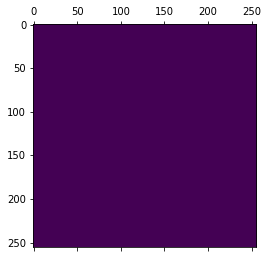

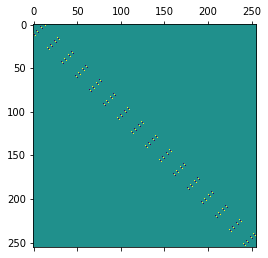

In [305]:
D = get_D_op(2, unit_number=2)
imD = np.imag(D.toarray())
plt.matshow(imD)
reD = np.real(D.toarray())
plt.matshow(reD)
Dsq = D.dot(D)
print(Dsq.toarray())
# np.linalg.eigvals(Dsq)

Test the creation and annihilation operators

In [288]:
def anticommutor(m1, m2):
    return m1.dot(m2) + m2.dot(m1)

def commutor(m1, m2):
    return m1.dot(m2) - m2.dot(m1)

ap = get_creator(1, 1)
an = get_annihilator(1, 1)

print("Test whether or not the Hermitian conjugate of the creator is the annihilator: \n", (ap.conjugate().transpose() - an).toarray())

print("Test whether or not they obey the Fermionic relation:\n",'{a^\dagger, a} = \n', (anticommutor(ap, an)).toarray())

Test whether or not the Hermitian conjugate of the creator is the annihilator: 
 [[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
Test whether or not they obey the Fermionic relation:
 {a^\dagger, a} = 
 [[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]]


In [291]:
ap1 = get_creator(1, 0)
ap2 = get_creator(1, 1)
an1 = get_annihilator(0, 1)
an2 = get_annihilator(1, 1)
anticommutor(ap1, an1)
# commutor(ap1, an1)

<4096x4096 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Row format>

which shows that `get_creator` and `get_annihilator` are consistent.

In [314]:
d = get_d_op(1, 0)
d.conjugate().transpose() - d

<4096x4096 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Row format>

which shows that `d` is Hermitian.

In [313]:
d1 = get_d_op(1, 0)
d2 = get_d_op(2, 0)
anticommutor(d1, d2)

<4096x4096 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Column format>

In [316]:
d1 = get_d_op(1, 0)
d2 = get_d_op(2, 1)
anticommutor(d1, d2)

<4096x4096 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Column format>

In [317]:
d1 = get_d_op(1, 0)
d2 = get_d_op(1, 1)
anticommutor(d1, d2)

<4096x4096 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Column format>

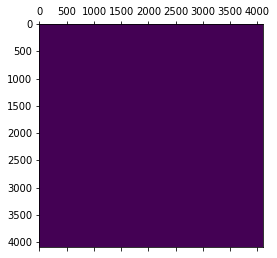

In [318]:
c1 = get_c_op(1, 0)
c2 = get_c_op(0, 1)
antic = (c1.dot(c2) + c2.dot(c1)).toarray()
plt.matshow(np.real(antic))
# plt.colorbar()
plt.show()

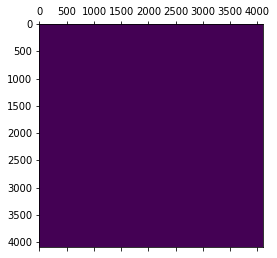

In [230]:
antic = (d1.dot(c2) + c2.dot(d1)).toarray()
plt.matshow(np.real(antic))
# plt.colorbar()
plt.show()

In [136]:
j=1
alpha=0
width=2
[Sigma(3, get_site_number_from_row_column(i, alpha, width=width)) for i in range(j)]

[<4096x4096 sparse matrix of type '<class 'numpy.float64'>'
 	with 4096 stored elements in COOrdinate format>]

In [155]:
j = 2
sign = -1 if j % 2 == 1 else 1
print(sign)

1


Extract the eigenvalues of local symmetries

In [ ]:
unit_number = 3
L = unit_number * 2
D_list = [get_D_op(i) for i in range(L)]

In [29]:
Jx=1
Jy=1
Jz=1
H = get_H_Kitaev_Ladder2(Jx=Jx,Jy=Jy,Jz=Jz,bc='open',unit_number=unit_number)
H = H.toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for D in D_list:
    print("D @ v0 @ v1 = ", D@v0@v1)
    print("D @ v1 @ v0 = ", D@v1@v0)

D @ v0 @ v1 =  (-0.9999999999999922+0j)
D @ v1 @ v0 =  (-0.9999999999999922+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.999999999999992+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)


In [31]:
Jx=1
Jy=-1
Jz=1
H = get_H_Kitaev_Ladder2(Jx=Jx,Jy=Jy,Jz=Jz,bc='open',unit_number=unit_number)
H = H.toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for D in D_list:
    print("D @ v0 @ v1 = ", D@v0@v1)
    print("D @ v1 @ v0 = ", D@v1@v0)

D @ v0 @ v1 =  (0.9999999999999922+0j)
D @ v1 @ v0 =  (0.9999999999999922+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.999999999999992+0j)
D @ v0 @ v1 =  (0.9999999999999921+0j)
D @ v1 @ v0 =  (0.9999999999999921+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)
D @ v0 @ v1 =  (0.9999999999999921+0j)
D @ v1 @ v0 =  (0.9999999999999921+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)


In [28]:
Jx=-1
Jy=-1
Jz=1
H = get_H_Kitaev_Ladder2(Jx=Jx,Jy=Jy,Jz=Jz,bc='open',unit_number=unit_number)
H = H.toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for D in D_list:
    print("D @ v0 @ v1 = ", D@v0@v1)
    print("D @ v1 @ v0 = ", D@v1@v0)

D @ v0 @ v1 =  (-0.9999999999999922+0j)
D @ v1 @ v0 =  (-0.9999999999999922+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.999999999999992+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)


In [30]:
Jx=-1
Jy=1
Jz=1
H = get_H_Kitaev_Ladder2(Jx=Jx,Jy=Jy,Jz=Jz,bc='open',unit_number=unit_number)
H = H.toarray()
E, V = np.linalg.eigh(H)
v0 = V[:, 0]
v1 = V[:, 1]
for D in D_list:
    print("D @ v0 @ v1 = ", D@v0@v1)
    print("D @ v1 @ v0 = ", D@v1@v0)

D @ v0 @ v1 =  (0.9999999999999922+0j)
D @ v1 @ v0 =  (0.9999999999999922+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.999999999999992+0j)
D @ v0 @ v1 =  (0.9999999999999921+0j)
D @ v1 @ v0 =  (0.9999999999999921+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)
D @ v0 @ v1 =  (0.9999999999999921+0j)
D @ v1 @ v0 =  (0.9999999999999921+0j)
D @ v0 @ v1 =  (-0.9999999999999921+0j)
D @ v1 @ v0 =  (-0.9999999999999921+0j)


In [18]:
Jx = 1
Jy = 1
Jz = 1
E, V = exact_diagonalization_Kitaev_Ladder(Jx=Jx, Jy=Jy, Jz=Jz, k=3)

The 3 lowest energies are: 
 [-9.50760815 -9.50760815 -9.15624404]


In [51]:
v0 = V[:,0]
v1 = V[:,1]
v2 = V[:,2]
D = get_D_op(0)
# print("The first ground state: ", v0)
# print("Transformed by D", D.dot(v0))
# print("The second ground state: ", v1)
# print("Transformed by D", D.dot(v1))

In [44]:
(-3.60966752e-03+6.65190888e-03j) / (1.86049916e-03+2.07268857e-03j)

(0.911576750707381+2.5597937749840596j)

In [45]:
(-2.60155955e-18+9.31323951e-18j) / (9.40323789e-19+5.49848587e-18j)

(1.5670384910982036+0.7411282338092661j)

In [319]:
H = get_H_Kitaev_Ladder(Jx=Jx, Jy=Jy, Jz=Jz)

In [35]:
v0

array([ 1.86049916e-03+2.07268857e-03j,  9.40323789e-19+5.49848587e-18j,
        3.44159593e-18+1.13195761e-17j, ...,
       -4.21478257e-18-6.65348111e-18j,  1.67314274e-17-1.61308621e-17j,
       -1.86049916e-03-2.07268857e-03j])

In [55]:
H.count_nonzero()

43776

In [50]:
H.dot(v1) / v1

array([ -9.15624404+9.96558615e-14j,  -7.81058717-2.12428305e+00j,
       -13.8080642 -3.91725214e+00j, ...,  -6.36891772-2.52855558e+00j,
        -9.33958834+5.76256783e-01j,  -9.15624404+4.03451066e-14j])

In [64]:
E, V = np.linalg.eigh(H.toarray())

In [65]:
Harray = H.toarray()

In [166]:
v0 = V[:, 0]
v1 = V[:, 1]

In [83]:
v0p = 

SyntaxError: invalid syntax (<ipython-input-83-592d8f7e9502>, line 1)

In [84]:
v0 @ v0p

(-0.09498334162309655+0j)

In [86]:
v0p = Harray @ v0

In [87]:
v0p

array([ 7.66734730e-02+0.j,  4.25134368e-17+0.j,  2.96636915e-16+0.j, ...,
       -1.65906061e-18+0.j, -1.64579952e-18+0.j, -7.66734730e-02+0.j])

In [88]:
v0

array([-8.06443343e-03+0.j,  1.38777878e-17+0.j,  2.77555756e-17+0.j, ...,
        1.75340111e-19+0.j,  1.74782300e-19+0.j,  8.06443343e-03+0.j])

/home/jerry/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


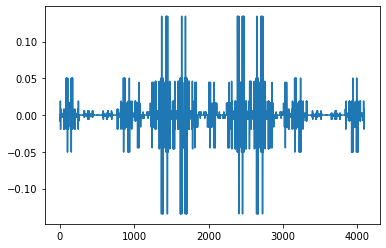

In [95]:
plt.plot(v0)

In [307]:
Darray = D.toarray()

In [308]:
Dv0 = Darray @ v0

In [309]:
HDv0 = Harray @ Darray @ v0

In [310]:
DHv0 = Darray @ Harray @ v0

In [311]:
HD = Harray @ Darray
DH = Darray @ Harray

In [312]:
dif = HD - DH
for i in range(dif.shape[0]):
    for j in range(dif.shape[1]):
        value = dif[i, j]
        if np.linalg.norm(value) > 1e-10:
            print(value)

(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-

(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2+0j)
(2+0j)
(-2+0j)
(-2+0j)
(2

KeyboardInterrupt: 

In [161]:
H @ v0

array([ 7.66734730e-02+0.j,  4.25134368e-17+0.j,  2.96636915e-16+0.j, ...,
       -1.65906061e-18+0.j, -1.64579952e-18+0.j, -7.66734730e-02+0.j])

In [298]:
Dv0 = Darray @ v0
HDv0 = Harray @ Dv0
HDv0 @ Dv0

(-5.413196142182751+0j)

In [164]:
Dv0 @ v0

(9.62964972193618e-35+0j)

In [165]:
E

array([-9.50760815, -9.50760815, -9.15624404, ...,  9.15624404,
        9.50760815,  9.50760815])

In [169]:
Harray @ Darray @ v1 @ v0

(9.507608149965048+0j)

In [170]:
D2 = get_D_op(1)
Harray @ D2.toarray() @ v1 @ v0

(9.507608149965048+0j)

In [171]:
D2.toarray() @ v1 @ v0

(-0.9999999999999993+0j)

In [172]:
D2.toarray() @ v0 @ v1

(0.9999999999999996+0j)

In [296]:
D.toarray() @ v0 @ v0

(8.229100951235836e-08+0j)

In [297]:
Darray = D.toarray()

In [175]:
np.linalg.eig(np.array([[0, 1], [-1, 0]]))

(array([0.+1.j, 0.-1.j]),
 array([[0.70710678+0.j        , 0.70710678-0.j        ],
        [0.        +0.70710678j, 0.        -0.70710678j]]))

In [320]:
H.dot(D) - D.dot(H)

<4096x4096 sparse matrix of type '<class 'numpy.complex128'>'
	with 8192 stored elements in Compressed Sparse Row format>

In [17]:
def get_H_Kitaev_Ladder2(Jx=1, Jy=1, Jz=1, unit_number=3, bc='open'):
    # parameter setting
    unit_size = 4
    L = unit_number * unit_size

    H_xx = sparse.csr_matrix((2**L, 2**L))
    for i in range(L//2 - 1):
        site1 = 2*i
        site2 = site1 +3

        op_num = 1 # 1 represents x

    #     print("i = ", i)
        X1 = Sigma(op_num, site1, L=L)
        X2 = Sigma(op_num, site2, L=L)
        H_xx += X1.dot(X2)

        pass

    H_yy = sparse.csr_matrix((2**L, 2**L))
    for i in range(L//2 - 1):
        site1 = 2*i + 1
        site2 = site1+1

        op_num = 2
        Y1 = Sigma(op_num, site1, L=L)
        Y2 = Sigma(op_num, site2, L=L)
        H_yy += Y1.dot(Y2)

        pass
    
    if bc=='periodic':
        XN = Sigma(1, L-1, L=L)
        X1 = Sigma(1, 0, L=L)
        H_xx += XN.dot(X1)
        
        YN = Sigma(2, L-2, L=L)
        Y1 = Sigma(2, 1, L=L)
        H_yy += YN.dot(Y1)
        pass

    H_zz = sparse.csr_matrix((2**L, 2**L))
    for i in range(L//2):
        site1 = 2*i
        site2 = site1 +1

        op_num = 3
        Z1 = Sigma(op_num, site1, L=L)
        Z2 = Sigma(op_num, site2, L=L)
        H_zz += Z1.dot(Z2)

        pass

    H = Jx * H_xx + Jy * H_yy + Jz * H_zz
    
    return H

H = get_H_Kitaev_Ladder2()

In [322]:
H.dot(D) - D.dot(H)

<4096x4096 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Row format>

In [323]:
Harray = H.toarray()
Darray = D.toarray()

E, V = np.linalg.eigh(Harray)
E

array([-9.50760815, -9.50760815, -9.15624404, ...,  9.15624404,
        9.50760815,  9.50760815])

In [324]:
v0 = V[:, 0]
v1 = V[:, 1]

In [325]:
Harray @ v0 @ v0

(-9.507608149965046+0j)

In [326]:
Harray @ v1 @ v1

(-9.507608149965048+0j)

In [328]:
Darray @ v0 @ v0

(-1.266076697848374e-07+0j)

In [329]:
Darray @ v0 @ v1

(-0.9999999999999922+0j)

In [331]:
Darray @ v1 @ v0

(-0.9999999999999922+0j)

In [333]:
D1 = get_D_op(j=1).toarray()


In [334]:
D1 @ v0 @ v1

(-0.9999999999999921+0j)

In [335]:
D1 @ v1 @ v0

(-0.999999999999992+0j)

In [336]:
H = get_H_Kitaev_Ladder2(Jx=1, Jy=-1, Jz=1).toarray()
E, V = np.linalg.eigh(H)

NameError: name 'v' is not defined

In [337]:

v0 = V[:, 0]
v1 = V[:, 1]
print(Darray @ v0 @ v1)
print(Darray @ v1 @ v0)
print(D1 @ v0 @ v1)
print(D1 @ v1 @ v0)

(0.9999999999999922+0j)
(0.9999999999999922+0j)
(-0.9999999999999921+0j)
(-0.999999999999992+0j)


### Perturbation

In [10]:
def get_H_Kitaev_Ladder3(Jx=1, Jy=1, Jz=1, length=3, bc='open'):
    # parameter setting
    L = 2 * length

    H_xx = sparse.csr_matrix((2**L, 2**L))
    for i in range(L//2 - 1):
        site1 = 2*i
        site2 = site1 +3

        op_num = 1 # 1 represents x

    #     print("i = ", i)
        X1 = Sigma(op_num, site1, L=L)
        X2 = Sigma(op_num, site2, L=L)
        H_xx += X1.dot(X2)

        pass

    H_yy = sparse.csr_matrix((2**L, 2**L))
    for i in range(L//2 - 1):
        site1 = 2*i + 1
        site2 = site1+1

        op_num = 2
        Y1 = Sigma(op_num, site1, L=L)
        Y2 = Sigma(op_num, site2, L=L)
        H_yy += Y1.dot(Y2)

        pass
    
    if bc=='periodic':
        XN = Sigma(1, L-1, L=L)
        X1 = Sigma(1, 0, L=L)
        H_xx += XN.dot(X1)
        
        YN = Sigma(2, L-2, L=L)
        Y1 = Sigma(2, 1, L=L)
        H_yy += YN.dot(Y1)
        pass

    H_zz = sparse.csr_matrix((2**L, 2**L))
    for i in range(L//2):
        site1 = 2*i
        site2 = site1 +1

        op_num = 3
        Z1 = Sigma(op_num, site1, L=L)
        Z2 = Sigma(op_num, site2, L=L)
        H_zz += Z1.dot(Z2)

        pass

    H = Jx * H_xx + Jy * H_yy + Jz * H_zz
    
    # Bias
#     for i in range(L//2 - 1):
#         site = 2*i
#         H += Sigma(3, site, L=L)
        
#     site = L//3
#     H += Sigma(1, site, L=L)
    site1 = L//2 - 1
    s1 = Sigma(1, site1, L=L) + Sigma(2, site1, L=L)
    site2 = site1 + 1
    s2 = Sigma(1, site2, L=L) + Sigma(2, site2, L=L)
    H += s1.dot(s2)
    
    return H

H = get_H_Kitaev_Ladder3(Jx=rand(), Jy=rand(), Jz=rand(), length=5).toarray()
np.linalg.eigvalsh(H)[:10]

array([-5.78890584, -5.78108567, -5.78108567, -5.77279402, -5.74646891,
       -5.74646891, -5.73806704, -5.73806704, -5.73163587, -5.73163587])

In [7]:
np.linalg.eigvalsh(get_H_Kitaev_Ladder3(Jx=rand(), Jy=rand(), Jz=rand(), length=6).toarray())[:10]

array([-2.10884011, -2.10884011, -2.10884011, -2.10884011, -2.09959663,
       -2.09959663, -2.09959663, -2.09959663, -2.09886736, -2.09886736])